In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import matplotlib.pyplot as plt

NotFoundError: C:\Users\HP\anaconda3\lib\site-packages\tensorflow_text\python\ops\_regex_split_ops.so not found

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("spam.csv",encoding ='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df= df[['v1', 'v2']].rename(columns={"v1": "Category", "v2": "Message"})
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


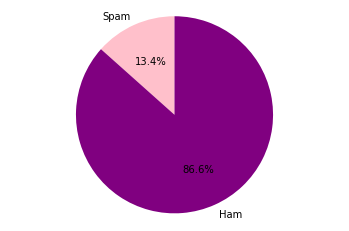

In [20]:
labels= ['Spam', 'Ham']

nb_spam = len(df[df.Category=='spam'])

plt.pie([nb_spam, len(df)-nb_spam],labels=labels, colors=['pink', 'purple'], startangle=90, autopct='%1.1f%%')

plt.axis('equal')

plt.show()

In [21]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64